# Assignment 2. Coding Question 1 by [Rufaim](https://github.com/Rufaim)

---
4-step SARSA, 4-step Expected SARSA, and 4-step Q-learning algorithms (see chapter 10 Sutton and Barto, 2018) with a two layered Neural Network (64 hidden units in each layer) to learn the task. 
Use experience replay to stabilize the learning process.
For exploration use an $\varepsilon$-greedy policy with $\varepsilon$ = 0.1.

Run all 3 algorithms with the following sizes of experience replay buffers: 50,100, 250, 500.

Use the CartPole environment from Open AI gym.
Set the discount factor $\gamma$ to 0.9.

Present your results in two different plots. 
 1. In the first plot, the $x$-axis should show the learning rate and the $y$-axis the average return on the last 10 episodes of training (you must train until convergence). In this plot, you will have 4 different lines: one line for each variant of experience replay.
 2. For the second plot, choose the best combination of experience replay and learning rate. Forthis combination, present a plot with episodes in $x$-axis and the return obtained in the corresponding episode as $y$-axis. 

Run all the experiments on 20 different seeds. Also show the confidence interval (using the standard deviation obtained from the runs).

#### References

1. Sutton, Richard S and Andrew G Barto (2018). Reinforcement learning: An introduction. MIT press.

## Imports and Global constants

In [0]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as pyplot
import matplotlib.colors as mcolors
import gym

In [0]:
# Some gpu configy magic 
gpus = tf.config.list_physical_devices('GPU')
# Out of jokes it is highly recommended to run the following experiments on gpu
for gpu in gpus:
    tf.config.set_logical_device_configuration(gpu,
    [tf.config.LogicalDeviceConfiguration(memory_limit=3*1024)])

In [0]:
from itertools import product, cycle

GREEDY_EPS is a chance to make a random action instead of greedly choosing action with higher probability.

N_STEPS number of steps to unroll tragectories

NUM_TEST_STEPS we are averaging for to treat as a test

NUM_EPISODES is a maximum number of episodes to run model. If there is no convergence happen before NUM_EPISODES model could be considered diverged

NUM_TRIALS is a numre of reruns for experiment with differend seeds. It was intended to be 20, but it was halfed gue to enormous amount of time experiments take

ALPHA is a smooth coefficient for target net update

---

Default parameters are:
```python
GREEDY_EPS = 0.1
N_STEPS = 4
NUM_TEST_STEPS = 10
NUM_EPISODES = 1200
NUM_TRIALS = 10
GAMMA = 0.9
ALPHA = 0.01
BATCH_SIZE = 32
SEED = 42
```

In [0]:
GREEDY_EPS = 0.1
N_STEPS = 4
NUM_TEST_STEPS = 10
NUM_EPISODES = 1200
NUM_TRIALS = 10
GAMMA = 0.9
ALPHA = 0.01
BATCH_SIZE = 32
SEED = 42

## Replay Buffer

Replay buffer is one of the two core technic we use to tame naturally unstable reinforcement learning process.

Replay buffer is wanted to be able to store records and form minibatches.

In [0]:
class ReplayBuffer(object):
    def __init__(self,capacity,gamma,seed=None):
        self.capacity = capacity
        self.gamma = gamma  # note that gamma here is a  real discount factor
        self.random_generator = np.random.RandomState(seed)
        self.buffer = []
    def __len__(self):
        return len(self.buffer)
        
    def add(self,state,action,reward,is_terminal):
        # fun fact records stored in SART instead of SARS or SARSA
        self.buffer.append((state,action[0],reward,is_terminal))
        if len(self.buffer) >= self.capacity:
            self.buffer.pop(0)
    
    def minibatch(self,batch_size,num_sequential=1):
        last = len(self.buffer) - num_sequential
        idx = self.random_generator.randint(0,last,size=batch_size)
        states_0 = []
        actions_0 = []
        states_n = []
        actions_n = []
        targets = []
        terminals = []  # we will need this things later to properly calculate targets
        for i in idx:
            # please note that tuples stored sequentially
            # so we can unroll by just moving forward from any locations 
            seq = [self.buffer[i+j] for j in range(num_sequential+1)]
            states_0.append(seq[0][0])
            actions_0.append(seq[0][1])
            states_n.append(seq[-1][0])
            actions_n.append(seq[-1][1])
            G = 0
            for k,(_,_,r,t) in enumerate(seq):
                G += self.gamma**k * r
                if t:
                    # unrolling till termination
                    break
            targets.append(G)
            terminals.append(t)
        return np.array(states_0,dtype=np.float32), np.array(actions_0,dtype=np.int32),\
                 np.array(targets,dtype=np.float32), np.array(states_n,dtype=np.float32), \
                 np.array(actions_n,dtype=np.int32), np.array(terminals,dtype=np.bool)

## Neural Agents

Our agents are neural networks trained in order to optimize difference between target q-values and output of the network.

$$
Loss = \frac{1}{2}\sum_{i=1}^B \left( \hat{q}_i - q(s,a)\right) 
$$
where $q(s,a)$ is an output of our agent and $B$ is a batch size.

$$
\hat{q}_i = \sum_{j=0}^{N_{steps}-1} \gamma^jr_j + \gamma^{N_{steps}} f(s_{i+N_{steps}},a_{i+N_{steps}})
$$

So target q-values are unrolled rewards plus some discounted function that approximates the tail of the sum.

The real difference between SARSA, Expected SARSA and Q-learning is a way of how tail approximation is computed.

For **SARSA** we know state and action and use q-value for this state and action directly:

$$
f(s_{i+N_{steps}},a_{i+N_{steps}}) = q(s_{i+N_{steps}},a_{i+N_{steps}})
$$

For **Expected SARSA** we utilizing expectation over q-values:

$$
f(s_{i+N_{steps}},a_{i+N_{steps}}) = \sum_{a} \pi(a|s_{i+N_{steps}}) q(s_{i+N_{steps}},a)
$$

For **Q-learning** we taking maximum over q-values:

$$
f(s_{i+N_{steps}},a_{i+N_{steps}}) = \underset{a}{\max} \, q(s_{i+N_{steps}},a)
$$

In [0]:
class QNeuralNetwork(tf.keras.Model):
    def __init__(self, state_size, action_size,seed=None):
        super(QNeuralNetwork, self).__init__()
        '''Here you can see the most common an conventional
        Neural network with two hidden layers and relu activations
        By the way this model does not have any option to ajust 
        number of layers or number of units in them.
        '''
        self.state_size = state_size
        self.action_size = action_size
        self.input_layer = tf.keras.layers.InputLayer(input_shape=(state_size,))
        initializer = tf.keras.initializers.GlorotNormal(seed=seed)
        self.hidden_1_layer = tf.keras.layers.Dense(64,activation=tf.nn.relu,\
                                kernel_initializer=initializer)
        self.hidden_2_layer = tf.keras.layers.Dense(64,activation=tf.nn.relu,\
                                kernel_initializer=initializer)
        self.output_layer = tf.keras.layers.Dense(action_size,kernel_initializer=initializer)

    @tf.function
    def call(self, inputs):
        # technically the same model could be achived with
        # tf.keras.Sequential, but i like to do it in a manual way
        out = self.input_layer(inputs)
        out = self.hidden_1_layer(out)
        out = self.hidden_2_layer(out)
        out = self.output_layer(out)
        return out

In [0]:
class QAgent(object):
    def __init__(self,qnn,qnn_target,alpha,gamma,learning_rate,seed=None):
        # note: gamma here is really a gamma**n_steps,
        #       but for no reason we still refer it as gamma
        self.qnn = qnn  # this is our primary net
        # in ths model target network is used to stabilize learning process
        self.qnn_target = qnn_target # this net is used to produce targets

        # to make sure both nets start from the same point
        for v1, v2 in zip(self.qnn_target.trainable_variables, self.qnn.trainable_variables):
            v1.assign(v2)

        self.alpha = alpha
        self.gamma = gamma
        self.optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
        self.random_generator = np.random.RandomState(seed)
    
    def get_action(self,state):
        # this is a wrapper around tensorflowered function below
        s = np.atleast_2d(state)
        return self._get_action(s).numpy() # so we have numpy input and numpy output
    
    def get_eps_greedy_action(self,state,eps):
        # it takes epsilon so random action probability could be changed during run
        s = np.atleast_2d(state)
        is_real = self.random_generator.random(size=s.shape[0]) > eps
        random_action = self.random_generator.randint(0, self.qnn.action_size, size=s.shape[0])
        return self._get_eps_greedy_action(is_real, random_action,s).numpy()

    @tf.function
    def _get_action(self,state):
        return tf.argmax(self.qnn(tf.cast(state, tf.float32)),axis=1)
    
    @tf.function
    def _get_eps_greedy_action(self,is_real, random_action, state):
        real_actions = self._get_action(state)
        return tf.where(is_real,real_actions,random_action)
    
    @tf.function
    def update_step(self,states,actions,Gs,states_n,actions_n,terminals):
        # all three algorithms we are going to consider are differend in target calculation only
        q_vals_next = self._compute_q_vals_next(states_n,actions_n)
        # for non-terminated targets calculated q-values are added
        targets = tf.where(terminals, Gs, Gs+self.gamma*q_vals_next)

        with tf.GradientTape() as tape:
            picked_q_vals = self._pick_values(states,actions)
            # See? we are optimizing plain mse loss. Simple!
            loss = tf.constant(0.5)*tf.reduce_sum((targets - picked_q_vals)**2)
        variables = self.qnn.trainable_variables
        gradients = tape.gradient(loss, variables)
        self.optimizer.apply_gradients(zip(gradients, variables))
        alpha = tf.constant(self.alpha)
        target_variables = self.qnn_target.trainable_variables
        # it is very important to do not forget about target net update
        for v1, v2 in zip(target_variables, variables):
            v1.assign((1-alpha)*v1+alpha*v2) #we are using exp-smooth update

    @tf.function
    def _pick_values(self,states,actions_idx):
        q_vals = self.qnn(tf.cast(states, tf.float32))
        mask = tf.one_hot(tf.cast(actions_idx, tf.int32), self.qnn.action_size)
        # this masking thing is the most painless way to pick values from the array
        return tf.reduce_sum(q_vals * mask, axis=1)

    def _compute_q_vals_next(self,states_n,actions_n):
        '''This method is to be implemented in our algorithms
        '''
        raise NotImplementedError

In [0]:
class SARSA(QAgent):
    @tf.function
    def _compute_q_vals_next(self,states_n,actions_n):
        # for sarsa everything is simple, we just know which action to choose
        # so let's repeat masking trick
        q_vals = self.qnn_target(tf.cast(states_n, tf.float32)) # target net!
        mask = tf.one_hot(tf.cast(actions_n, tf.int32), self.qnn_target.action_size)
        return tf.reduce_sum(q_vals * mask, axis=1)

In [0]:
class ExpectedSARSA(QAgent):
    @tf.function
    def _compute_q_vals_next(self,states_n,actions_n):
        q_vals = self.qnn_target(tf.cast(states_n, tf.float32)) # target net!
        # true it could be done with mean over q-values
        probs = tf.nn.softmax(q_vals)
        # this probabilities is just to make everything
        out = tf.reduce_sum(probs* q_vals,axis=-1)
        # consistent with original formulas
        return out

In [0]:
class QLearning(QAgent):
    @tf.function
    def _compute_q_vals_next(self,states_n,actions_n):
        q_vals = self.qnn_target(tf.cast(states_n, tf.float32)) # target net!
        # picking maximum value for q-learning
        return tf.reduce_max(q_vals,axis=1)

## Test Framework

Test Framework should be able to run experiments with differend seeds and record all results.

*Algorithm:*

$
\text{For each episode:} \\
\quad\text{Initialize s}\\
\quad\text{Initialize replay buffer}\\
\quad\text{Set } z \leftarrow 0\\
\quad\text{Until S is terminal:} \\
\quad\quad\text{Sample } A \sim \pi(\cdot | S)\\
\quad\quad\text{Take action } A \text{ and observe reward } R \text{ and next state } S\\
\quad\quad\text{Sample } batch \text{ from replay buffer } \\
\quad\quad\text{Peform gradient step to minimize } Loss = \frac{1}{2}\displaystyle\sum_{(s,a,s_n,a_n) \in batch} \left( \hat{q}_i - q(s,a)\right) \\
\quad\quad S \leftarrow S'
$



In [0]:
class TestFramework(object):
    ''' Behold our brand new Test Framework ver. 2.2q 
        which is surely completely renewed and now looks totally the same as ver. 2.1,
        but with primary seed renamed.
    '''
    def __init__(self, buffer_builder, env_builder, agent_builder, batch_size, \
                 Nsteps, max_episodes, num_trials, greedy_eps, n_test_steps,\
                 masterseed=None):
        self.buffer_builder = buffer_builder # input: replay_buffer_size, seed
        self.env_builder = env_builder      # input: seed
        self.agent_builder = agent_builder  # input: learning_rate, seed
        self.batch_size = batch_size
        self.Nsteps = Nsteps
        self.max_episodes = max_episodes
        self.num_trials = num_trials
        self.eps = greedy_eps
        self.n_test_steps = n_test_steps
        self.masterseed = masterseed # belongs to The Master, widely known as Missy's Seed
        self.reset()

    def reset(self):
        self.random_generator = np.random.RandomState(seed=self.masterseed)

    def run_episode(self, environment, agent, buffer):
        s = environment.reset()
        t = False
        cum_reward = 0
        while not t:
            a = agent.get_eps_greedy_action(s,self.eps)
            s_,r,t,_ = environment.step(a[0])
            buffer.add(s,a,r,t)

            if t:   
                # because environment we are using rewards agent for each
                # timestep without failing we add huge negative reward
                # at the failure step artificially to push agent toward
                # avoiding of such a sequence of steps
                r = -100

            if len(buffer) > self.batch_size + self.Nsteps:
                batch = buffer.minibatch(self.batch_size,self.Nsteps)
                agent.update_step(*batch)
            
            s = s_
            cum_reward += r
        return cum_reward + 100 # removing artificial reward (to erase all evidence of intervention)
    
    def run_trial(self,learning_rate,buffer_size,seed):
        # as always trial is a run of experiment with a particular seed
        buffer = self.buffer_builder(buffer_size,seed)
        env = self.env_builder(seed)
        agent = self.agent_builder(learning_rate,seed)
        
        prev_test_cum_reward = 0
        train_cum_rewards = np.zeros((self.max_episodes,))
        for i in range(self.max_episodes):
            # i have added some fancy logging to make sure experiment have not become suspended
            print("\r\t {} of {} (avg. Cum Reward: {:.2f})".format(i+1,self.max_episodes,prev_test_cum_reward),end="")
            cr = self.run_episode(env,agent,buffer)
            train_cum_rewards[i] = cr
            # this is a check of convergence
            # not very ideal but we have what we have
            if test_cum_reward > 170 and np.abs(test_cum_reward-prev_test_cum_reward) < 2:
                print("  Convergence")
                break
            prev_test_cum_reward = test_cum_reward
        else:
            print()
            test_cum_reward = np.mean(train_cum_rewards[-self.n_test_steps:].copy())
        return train_cum_rewards, test_cum_reward
    
    def run_experiment(self, buffer_sizes, learning_rates):
        # experiment manager is a core of the Test Framework
        # it controls seeds experiments run with and gather results
        seeds = self.random_generator.randint(0,1000000, size=self.num_trials)
        params = list(product(buffer_sizes,learning_rates))

        train_cum_rewards = np.zeros((len(seeds), len(params),self.max_episodes))
        test_crewards = np.zeros((len(seeds), len(params)))
        for i,seed in enumerate(seeds):
            # more logging
            print("Seed # {} of {}".format(i+1,self.num_trials))
            for j,(bs, lr) in enumerate(params):
                print("  Trial # {} of {} (seed:{}, buffer size: {}, learning rate: {})".format(j+1,len(params),seed,bs,lr))
                train_crs, test_cr = self.run_trial(lr,bs,seed)
                train_cum_rewards[i,j,:] = train_crs
                test_crewards[i,j] = test_cr
        
        return params, train_cum_rewards.mean(axis=0), train_cum_rewards.std(axis=0),\
                test_crewards.mean(axis=0), test_crewards.std(axis=0)

## Experiments

In [0]:
# if a person would like to reproduce the results they shall be awared that
# it is extremely easy and takes only a couple of eternities
# so it is recommended to save the results to, you know ... prevent things
def save_results(filename,params,train_cr,test_cr,test_cr_std,terminals):
    np.savez(filename,params=params,train_cr=train_cr,test_cr=test_cr,test_cr_std=test_cr_std,terminals=terminals)

def load_results(filename):
    f=np.load(filename)
    params = f["params"]
    train_cr = f["train_cr"]
    test_cr = f["test_cr"]
    test_cr_std = f["test_cr_std"]
    terminals = f["terminals"]
    return params, train_cr, test_cr, test_cr_std, terminals

In [0]:
def environment_builder(seed):
    env = gym.make('CartPole-v0')
    env.seed(int(seed))
    return env

replay_buffer_builder = lambda bs,seed: ReplayBuffer(bs,GAMMA,seed)

sarsa_agent_builder = lambda lr, seed: SARSA(QNeuralNetwork(4,2,seed),QNeuralNetwork(4,2,seed),ALPHA,GAMMA**N_STEPS,lr,seed)
expected_sarsa_agent_builder = lambda lr, seed: ExpectedSARSA(QNeuralNetwork(4,2,seed),QNeuralNetwork(4,2,seed),ALPHA,GAMMA**N_STEPS,lr,seed)
qlearning_agent_builder = lambda lr, seed: QLearning(QNeuralNetwork(4,2,seed),QNeuralNetwork(4,2,seed),ALPHA,GAMMA**N_STEPS,lr,seed)

In [0]:
sarsa_test_framework = TestFramework(replay_buffer_builder,environment_builder,sarsa_agent_builder,\
                                     BATCH_SIZE,N_STEPS,NUM_EPISODES,NUM_TRIALS,GREEDY_EPS,NUM_TEST_STEPS,SEED)
expected_sarsa_test_framework = TestFramework(replay_buffer_builder,environment_builder,expected_sarsa_agent_builder,\
                                     BATCH_SIZE,N_STEPS,NUM_EPISODES,NUM_TRIALS,GREEDY_EPS,NUM_TEST_STEPS,SEED)
qlearning_test_framework = TestFramework(replay_buffer_builder,environment_builder,qlearning_agent_builder,\
                                     BATCH_SIZE,N_STEPS,NUM_EPISODES,NUM_TRIALS,GREEDY_EPS,NUM_TEST_STEPS,SEED)

In [0]:
# we are testing for four buffer sizes
# and four learning rates which gives us sixteen experiments in total
# surely if you have time you can add more
replay_buffer_sizes = [50,100,250,500]
learning_rates = [0.0001,0.001,0.01,0.1]

In [0]:
params_sarsa, train_cr_sarsa, test_cr_sarsa, test_cr_std_sarsa, terminals_sarsa = sarsa_test_framework.run_experiment(replay_buffer_sizes,learning_rates)

Seed # 1 of 10
  Trial # 1 of 16 (seed:121958, buffer size: 50, learning rate: 0.0001)
	 1 of 1200 (avg. Cum Reward: 0.00)

/home/pavel/New_programms/RL_Assignment_2/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))
/home/pavel/.local/lib/python3.6/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/pavel/.local/lib/python3.6/site-packages/numpy/core/_methods.py:161: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


	 681 of 1200 (avg. Cum Reward: 191.09)  Convergence
  Trial # 2 of 16 (seed:121958, buffer size: 50, learning rate: 0.001)
	 83 of 1200 (avg. Cum Reward: 174.00)  Convergence
  Trial # 3 of 16 (seed:121958, buffer size: 50, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 52.82)
  Trial # 4 of 16 (seed:121958, buffer size: 50, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 13.64)
  Trial # 5 of 16 (seed:121958, buffer size: 100, learning rate: 0.0001)
	 770 of 1200 (avg. Cum Reward: 191.82)  Convergence
  Trial # 6 of 16 (seed:121958, buffer size: 100, learning rate: 0.001)
	 105 of 1200 (avg. Cum Reward: 179.18)  Convergence
  Trial # 7 of 16 (seed:121958, buffer size: 100, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 60.09)
  Trial # 8 of 16 (seed:121958, buffer size: 100, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 10.27)
  Trial # 9 of 16 (seed:121958, buffer size: 250, learning rate: 0.0001)
	 663 of 1200 (avg. Cum Reward: 181.55)  Convergence
  Trial

	 95 of 1200 (avg. Cum Reward: 185.45)  Convergence
  Trial # 7 of 16 (seed:259178, buffer size: 100, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 47.36)
  Trial # 8 of 16 (seed:259178, buffer size: 100, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 14.09)
  Trial # 9 of 16 (seed:259178, buffer size: 250, learning rate: 0.0001)
	 492 of 1200 (avg. Cum Reward: 173.09)  Convergence
  Trial # 10 of 16 (seed:259178, buffer size: 250, learning rate: 0.001)
	 57 of 1200 (avg. Cum Reward: 174.45)  Convergence
  Trial # 11 of 16 (seed:259178, buffer size: 250, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 37.36)
  Trial # 12 of 16 (seed:259178, buffer size: 250, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 12.73)
  Trial # 13 of 16 (seed:259178, buffer size: 500, learning rate: 0.0001)
	 501 of 1200 (avg. Cum Reward: 172.91)  Convergence
  Trial # 14 of 16 (seed:259178, buffer size: 500, learning rate: 0.001)
	 43 of 1200 (avg. Cum Reward: 174.91)  Convergence
 

	 1200 of 1200 (avg. Cum Reward: 41.55)
  Trial # 12 of 16 (seed:54886, buffer size: 250, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 25.27)
  Trial # 13 of 16 (seed:54886, buffer size: 500, learning rate: 0.0001)
	 470 of 1200 (avg. Cum Reward: 187.36)  Convergence
  Trial # 14 of 16 (seed:54886, buffer size: 500, learning rate: 0.001)
	 132 of 1200 (avg. Cum Reward: 186.36)  Convergence
  Trial # 15 of 16 (seed:54886, buffer size: 500, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 37.73)
  Trial # 16 of 16 (seed:54886, buffer size: 500, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 31.00)
Seed # 10 of 10
  Trial # 1 of 16 (seed:137337, buffer size: 50, learning rate: 0.0001)
	 1071 of 1200 (avg. Cum Reward: 180.36)  Convergence
  Trial # 2 of 16 (seed:137337, buffer size: 50, learning rate: 0.001)
	 120 of 1200 (avg. Cum Reward: 175.64)  Convergence
  Trial # 3 of 16 (seed:137337, buffer size: 50, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 10.64))
 

In [0]:
save_results("sarsa_results.npz",params_sarsa, train_cr_sarsa, test_cr_sarsa, test_cr_std_sarsa, terminals_sarsa)

In [0]:
params_esarsa, train_cr_esarsa,test_cr_esarsa, test_cr_std_esarsa, terminals_esarsa = expected_sarsa_test_framework.run_experiment(replay_buffer_sizes,learning_rates)

Seed # 1 of 10
  Trial # 1 of 16 (seed:121958, buffer size: 50, learning rate: 0.0001)
	 635 of 1200 (avg. Cum Reward: 169.18)  Convergence
  Trial # 2 of 16 (seed:121958, buffer size: 50, learning rate: 0.001)
	 274 of 1200 (avg. Cum Reward: 174.00)  Convergence
  Trial # 3 of 16 (seed:121958, buffer size: 50, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 47.91)
  Trial # 4 of 16 (seed:121958, buffer size: 50, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 12.18)
  Trial # 5 of 16 (seed:121958, buffer size: 100, learning rate: 0.0001)
	 730 of 1200 (avg. Cum Reward: 194.18)  Convergence
  Trial # 6 of 16 (seed:121958, buffer size: 100, learning rate: 0.001)
	 108 of 1200 (avg. Cum Reward: 176.00)  Convergence
  Trial # 7 of 16 (seed:121958, buffer size: 100, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 105.36)
  Trial # 8 of 16 (seed:121958, buffer size: 100, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 12.55)
  Trial # 9 of 16 (seed:121958, buffer size:

	 916 of 1200 (avg. Cum Reward: 197.82)  Convergence
  Trial # 6 of 16 (seed:259178, buffer size: 100, learning rate: 0.001)
	 110 of 1200 (avg. Cum Reward: 188.00)  Convergence
  Trial # 7 of 16 (seed:259178, buffer size: 100, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 61.18)
  Trial # 8 of 16 (seed:259178, buffer size: 100, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 9.18))
  Trial # 9 of 16 (seed:259178, buffer size: 250, learning rate: 0.0001)
	 556 of 1200 (avg. Cum Reward: 190.73)  Convergence
  Trial # 10 of 16 (seed:259178, buffer size: 250, learning rate: 0.001)
	 77 of 1200 (avg. Cum Reward: 177.18)  Convergence
  Trial # 11 of 16 (seed:259178, buffer size: 250, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 92.09))
  Trial # 12 of 16 (seed:259178, buffer size: 250, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 21.18)
  Trial # 13 of 16 (seed:259178, buffer size: 500, learning rate: 0.0001)
	 475 of 1200 (avg. Cum Reward: 177.36)  Convergence

	 71 of 1200 (avg. Cum Reward: 181.27)  Convergence
  Trial # 11 of 16 (seed:54886, buffer size: 250, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 47.73))
  Trial # 12 of 16 (seed:54886, buffer size: 250, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 11.00)
  Trial # 13 of 16 (seed:54886, buffer size: 500, learning rate: 0.0001)
	 443 of 1200 (avg. Cum Reward: 183.82)  Convergence
  Trial # 14 of 16 (seed:54886, buffer size: 500, learning rate: 0.001)
	 94 of 1200 (avg. Cum Reward: 170.27)  Convergence
  Trial # 15 of 16 (seed:54886, buffer size: 500, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 92.09)
  Trial # 16 of 16 (seed:54886, buffer size: 500, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 44.36)
Seed # 10 of 10
  Trial # 1 of 16 (seed:137337, buffer size: 50, learning rate: 0.0001)
	 1127 of 1200 (avg. Cum Reward: 173.27)  Convergence
  Trial # 2 of 16 (seed:137337, buffer size: 50, learning rate: 0.001)
	 82 of 1200 (avg. Cum Reward: 174.18)  Co

In [0]:
save_results("expected_sarsa_results.npz",params_esarsa, train_cr_esarsa,test_cr_esarsa, test_cr_std_esarsa, terminals_esarsa)

In [0]:
params_qlearning, train_cr_qlearning, test_cr_qlearning, test_cr_std_qlearning, terminals_qlearning = qlearning_test_framework.run_experiment(replay_buffer_sizes,learning_rates)

Seed # 1 of 10
  Trial # 1 of 16 (seed:121958, buffer size: 50, learning rate: 0.0001)
	 687 of 1200 (avg. Cum Reward: 170.73)  Convergence
  Trial # 2 of 16 (seed:121958, buffer size: 50, learning rate: 0.001)
	 65 of 1200 (avg. Cum Reward: 169.64)  Convergence
  Trial # 3 of 16 (seed:121958, buffer size: 50, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 39.18)
  Trial # 4 of 16 (seed:121958, buffer size: 50, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 13.82)
  Trial # 5 of 16 (seed:121958, buffer size: 100, learning rate: 0.0001)
	 670 of 1200 (avg. Cum Reward: 178.91)  Convergence
  Trial # 6 of 16 (seed:121958, buffer size: 100, learning rate: 0.001)
	 188 of 1200 (avg. Cum Reward: 181.27)  Convergence
  Trial # 7 of 16 (seed:121958, buffer size: 100, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 97.91))
  Trial # 8 of 16 (seed:121958, buffer size: 100, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 11.00)
  Trial # 9 of 16 (seed:121958, buffer size: 

	 661 of 1200 (avg. Cum Reward: 174.55)  Convergence
  Trial # 6 of 16 (seed:259178, buffer size: 100, learning rate: 0.001)
	 127 of 1200 (avg. Cum Reward: 191.18)  Convergence
  Trial # 7 of 16 (seed:259178, buffer size: 100, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 61.36)
  Trial # 8 of 16 (seed:259178, buffer size: 100, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 11.55)
  Trial # 9 of 16 (seed:259178, buffer size: 250, learning rate: 0.0001)
	 480 of 1200 (avg. Cum Reward: 170.73)  Convergence
  Trial # 10 of 16 (seed:259178, buffer size: 250, learning rate: 0.001)
	 80 of 1200 (avg. Cum Reward: 171.18)  Convergence
  Trial # 11 of 16 (seed:259178, buffer size: 250, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 43.18)
  Trial # 12 of 16 (seed:259178, buffer size: 250, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 20.09)
  Trial # 13 of 16 (seed:259178, buffer size: 500, learning rate: 0.0001)
	 574 of 1200 (avg. Cum Reward: 191.27)  Convergence


	 136 of 1200 (avg. Cum Reward: 180.55)  Convergence
  Trial # 11 of 16 (seed:54886, buffer size: 250, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 91.09)
  Trial # 12 of 16 (seed:54886, buffer size: 250, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 27.27)
  Trial # 13 of 16 (seed:54886, buffer size: 500, learning rate: 0.0001)
	 417 of 1200 (avg. Cum Reward: 173.36)  Convergence
  Trial # 14 of 16 (seed:54886, buffer size: 500, learning rate: 0.001)
	 64 of 1200 (avg. Cum Reward: 178.91)  Convergence
  Trial # 15 of 16 (seed:54886, buffer size: 500, learning rate: 0.01)
	 1200 of 1200 (avg. Cum Reward: 40.64)
  Trial # 16 of 16 (seed:54886, buffer size: 500, learning rate: 0.1)
	 1200 of 1200 (avg. Cum Reward: 15.82)
Seed # 10 of 10
  Trial # 1 of 16 (seed:137337, buffer size: 50, learning rate: 0.0001)
	 1200 of 1200 (avg. Cum Reward: 113.00)
  Trial # 2 of 16 (seed:137337, buffer size: 50, learning rate: 0.001)
	 111 of 1200 (avg. Cum Reward: 171.91)  Convergence
  

In [0]:
save_results("qlearning_results.npz",params_qlearning, train_cr_qlearning, train_cr_std_qlearning, test_cr_qlearning, test_cr_std_qlearning, terminals_qlearning)

In [0]:
params_sarsa, train_cr_sarsa, test_cr_sarsa, test_cr_std_sarsa, terminals_sarsa = load_results("sarsa_results.npz")
params_esarsa, train_cr_esarsa, test_cr_esarsa, test_cr_std_esarsa, terminals_esarsa = load_results("expected_sarsa_results.npz")
params_qlearning, train_cr_qlearning, test_cr_qlearning, test_cr_std_qlearning, terminals_qlearning = load_results("qlearning_results.npz")

In [0]:
def plot_algo_results(params,cum_rewards,cum_rewards_std,title):
    colors_ = cycle(mcolors.TABLEAU_COLORS)
    fig1, ax1 = pyplot.subplots(figsize=(16,11))
    fig2, ax2 = pyplot.subplots(figsize=(16,11))
    for rbs in replay_buffer_sizes:
        idxs = [i for i,(bs, lr) in enumerate(params) if bs == rbs]
        cr_ = cum_rewards[idxs]
        cr_std_ = cum_rewards_std[idxs]

        col = next(colors_)
        ax1.semilogx(learning_rates,cr_,c=col,label="buffer={}".format(rbs))
        ax2.semilogx(learning_rates,cr_,c=col,label="buffer={}".format(rbs))
        # confidence interval of one std is used here
        # so around 68% of all cureves shall fall into
        ax2.fill_between(learning_rates, cr_ - cr_std_, cr_ + cr_std_, color=col, alpha=0.1)

        # To make everything looks more clear there is also 
        # separate plots with confidence intervals
        pyplot.subplots(figsize=(16,11))
        pyplot.semilogx(learning_rates,cr_,c=col)
        pyplot.fill_between(learning_rates, cr_ - cr_std_, cr_ + cr_std_, color=col, alpha=0.2)
        pyplot.title(f"Test {title} with replay buffer of size {rbs}", fontsize=24, fontweight="bold")
        pyplot.xlabel("Learning rate", fontsize=16)
    
    ax1.set_title(f"Test {title} means", fontsize=24, fontweight="bold")
    ax2.set_title(f"Test {title} with confidence intervals", fontsize=24, fontweight="bold")
    ax1.legend(loc="best")
    ax2.legend(loc="best")
    ax1.set_xlabel("Learning rate", fontsize=16)
    ax2.set_xlabel("Learning rate", fontsize=16)

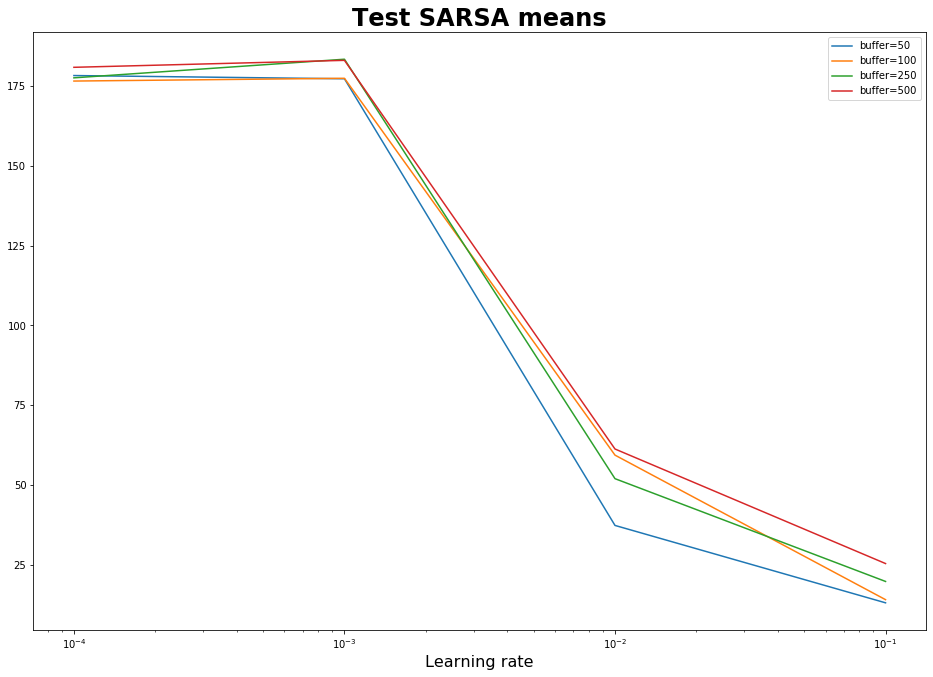

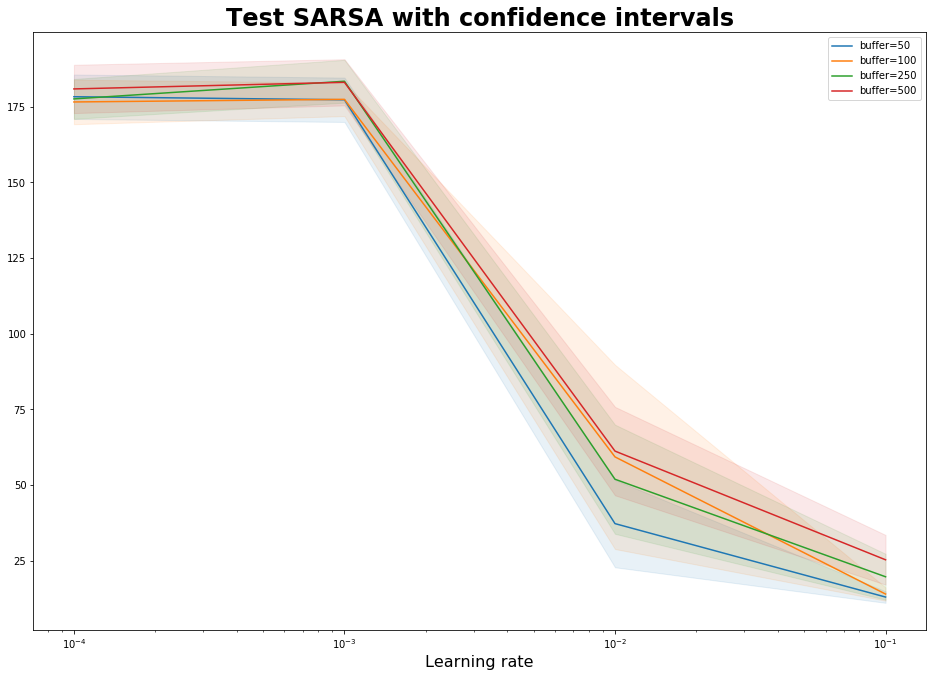

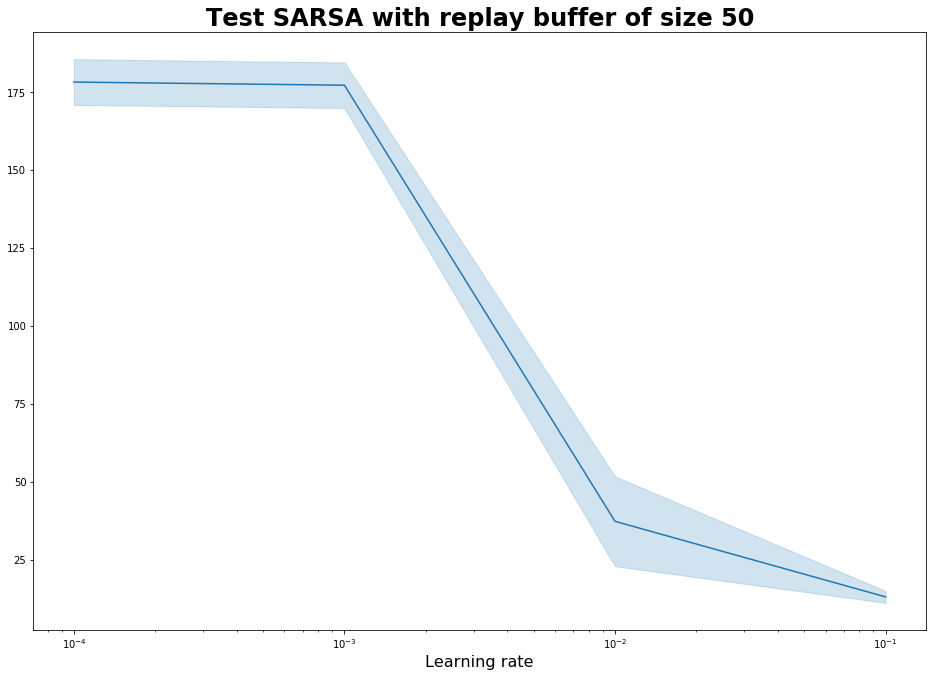

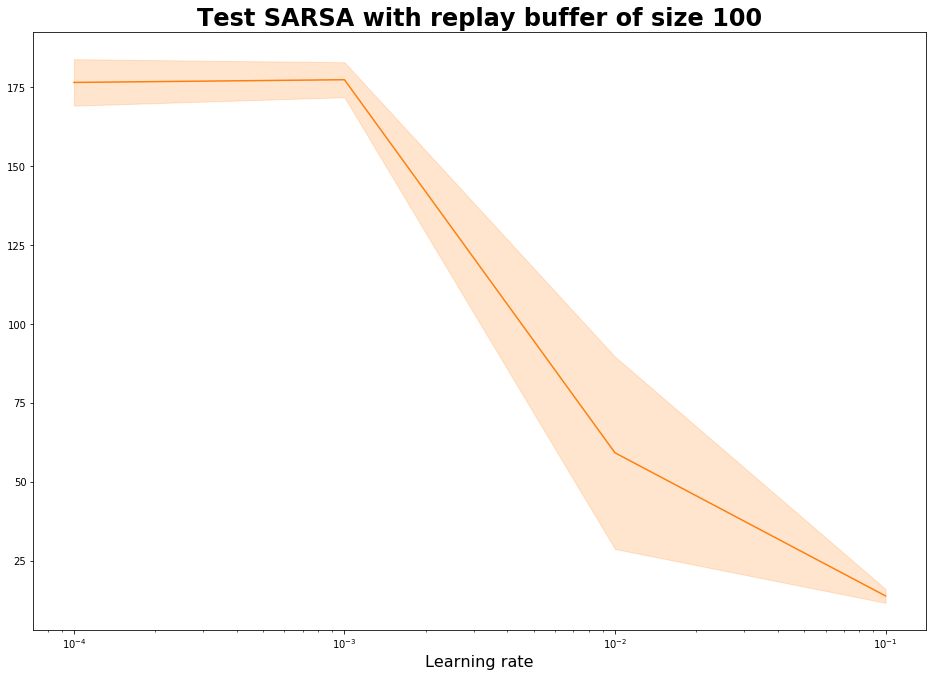

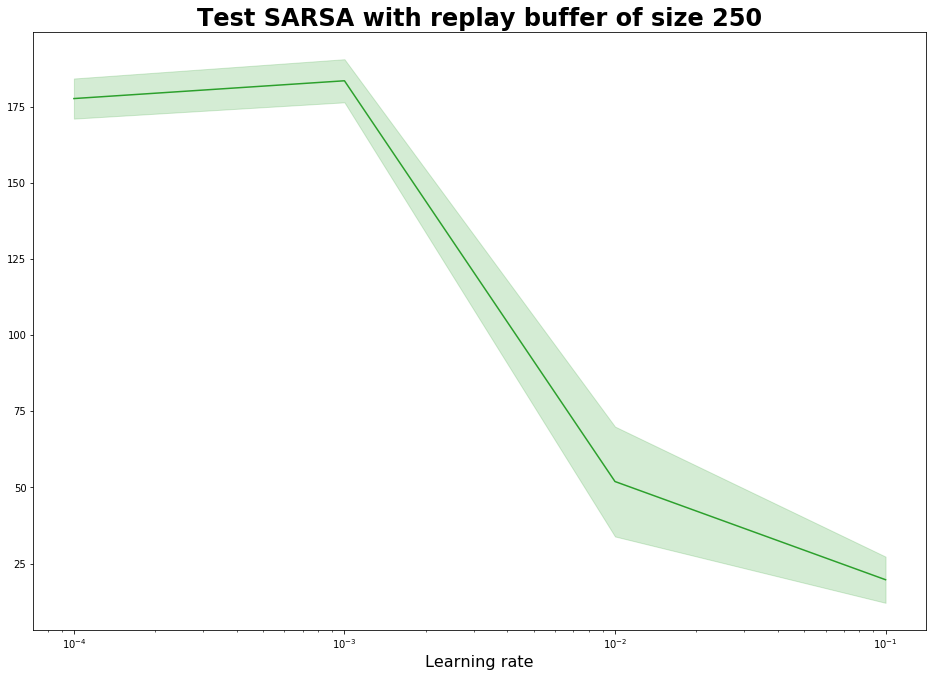

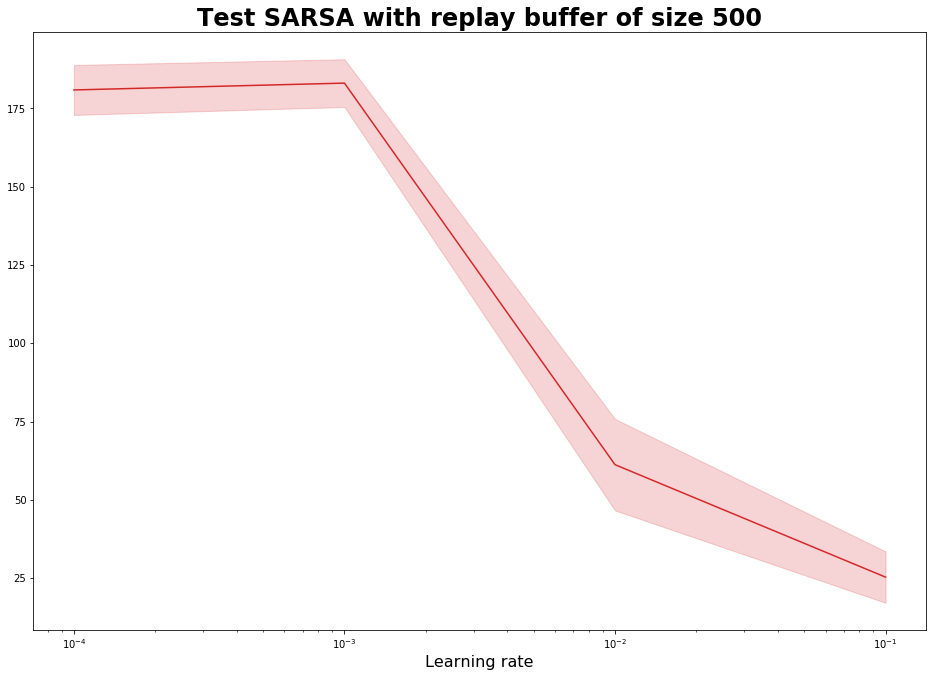

In [25]:
plot_algo_results(params_sarsa,test_cr_sarsa, test_cr_std_sarsa,"SARSA")

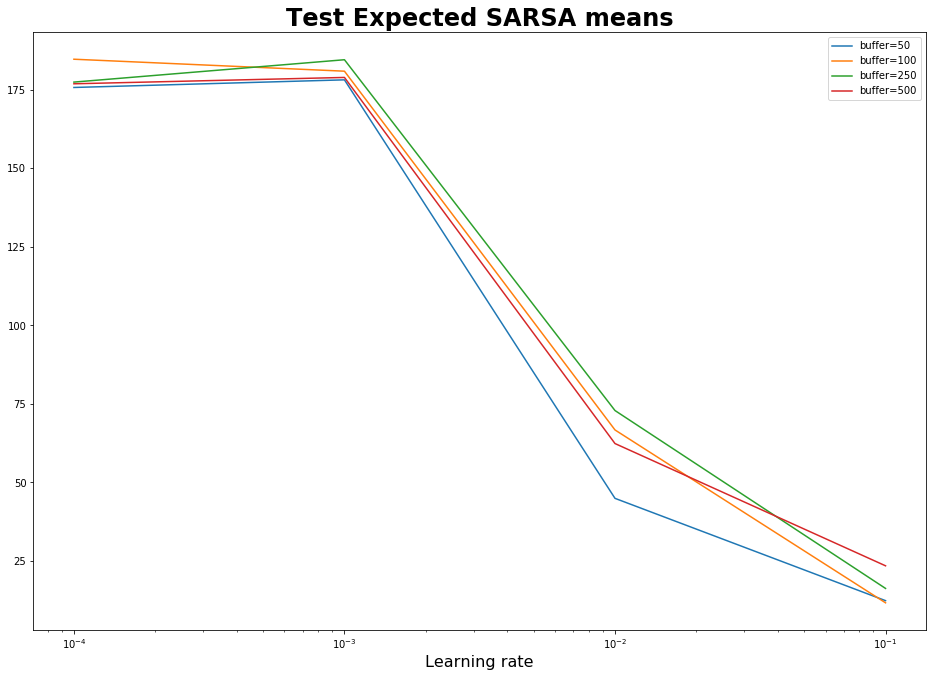

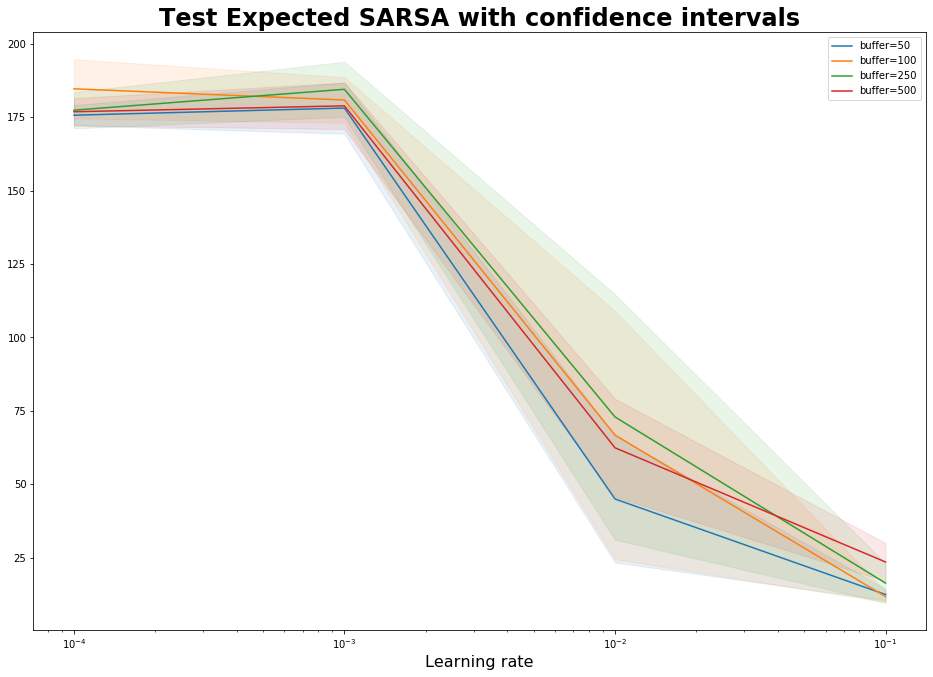

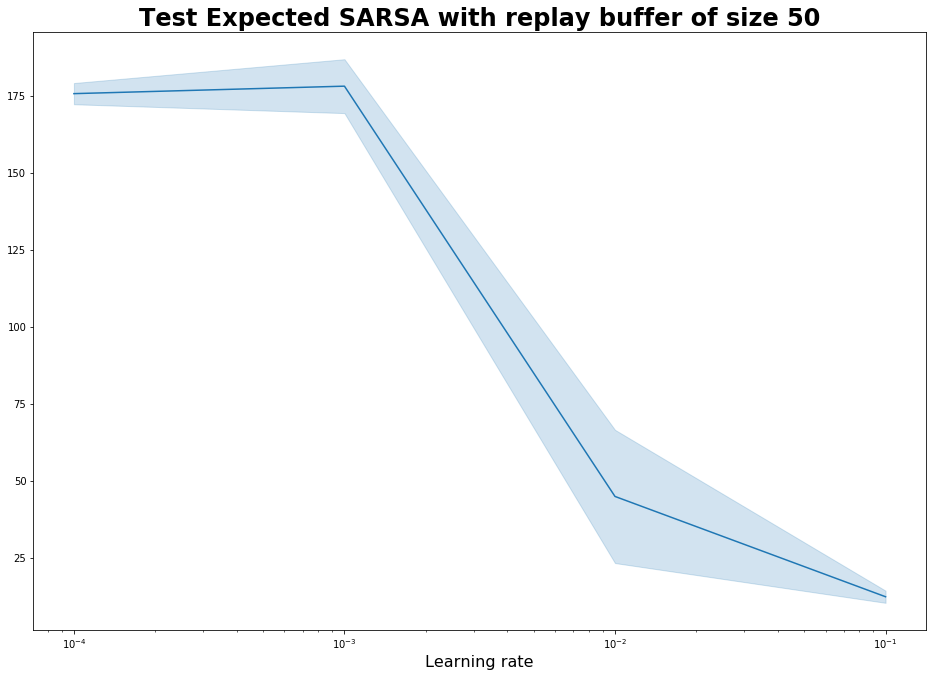

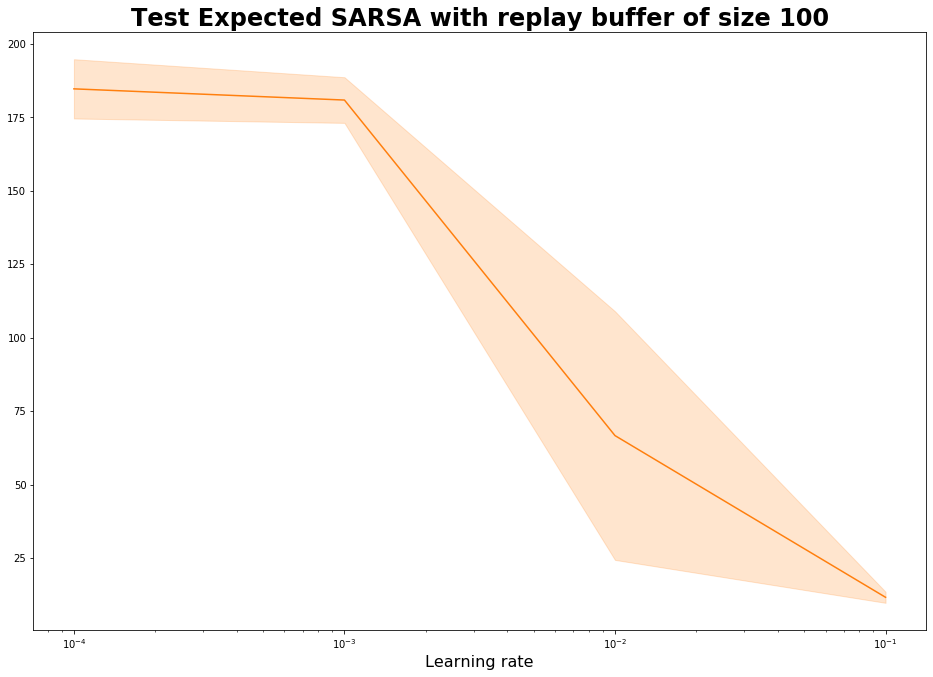

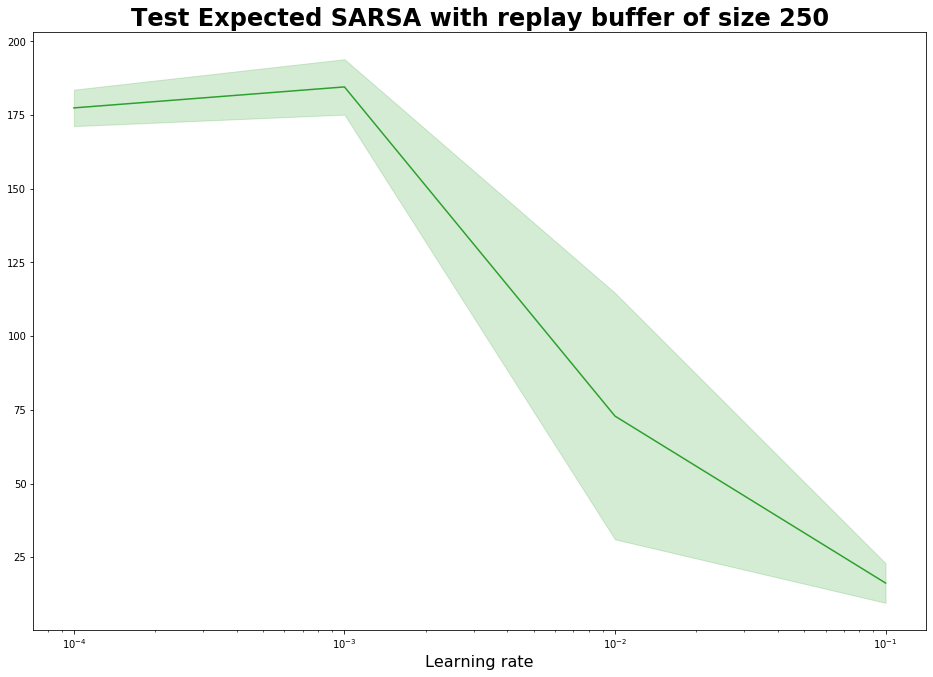

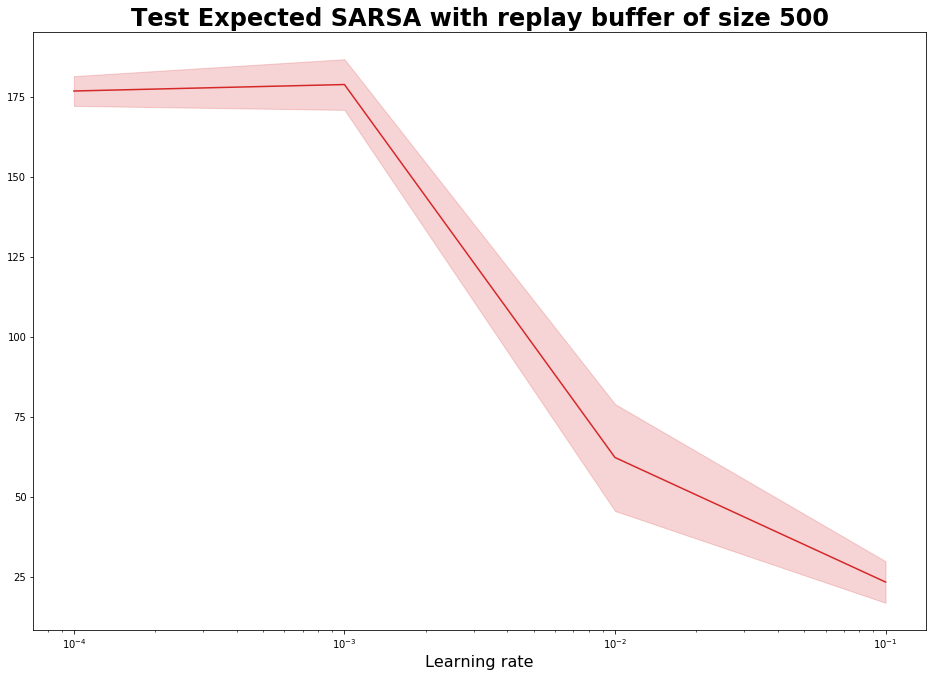

In [26]:
plot_algo_results(params_esarsa,test_cr_esarsa, test_cr_std_esarsa,"Expected SARSA")

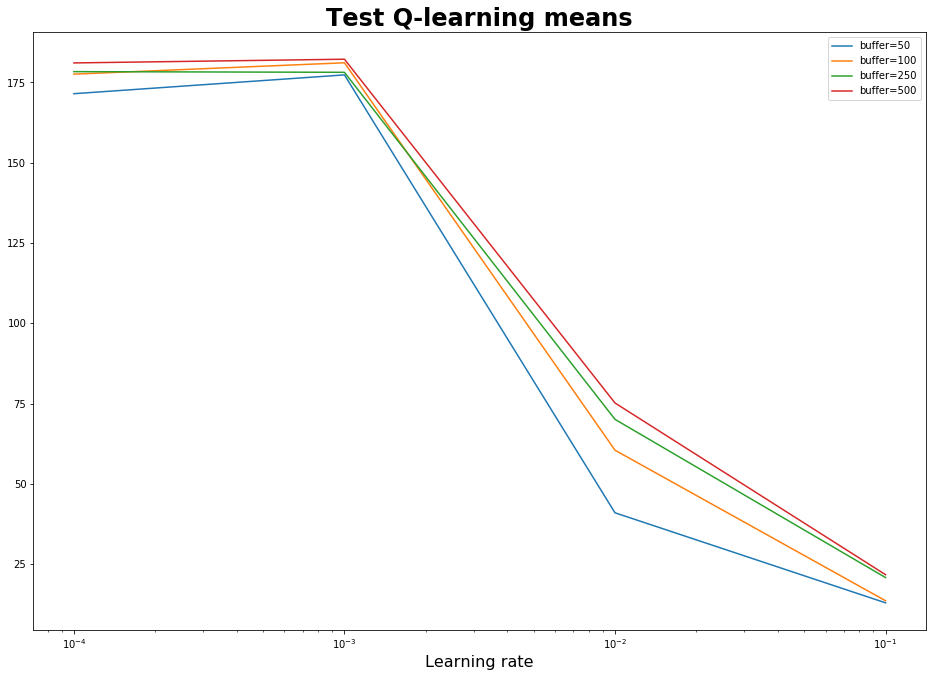

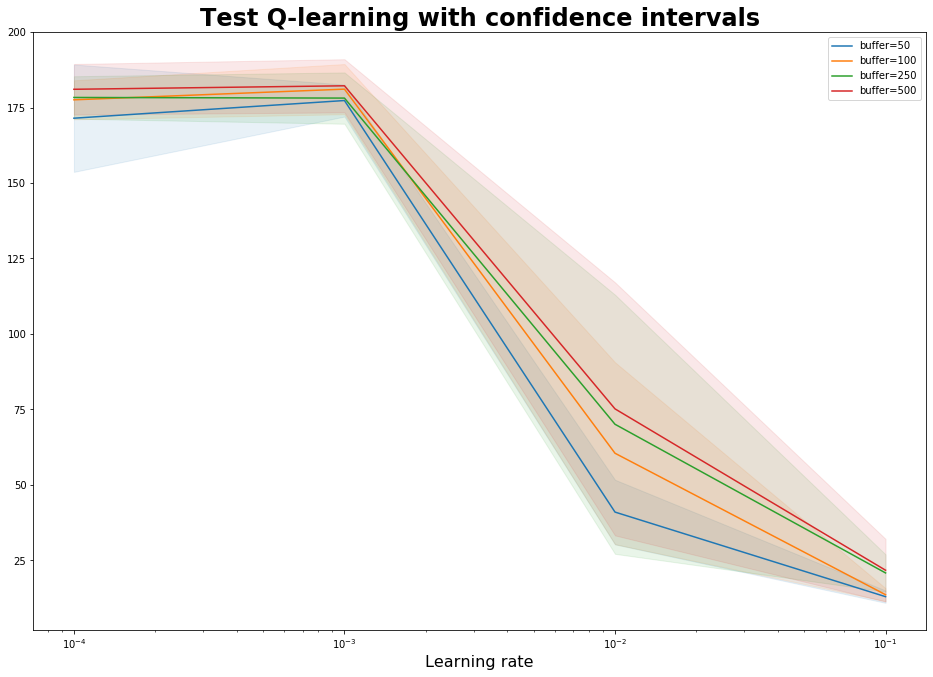

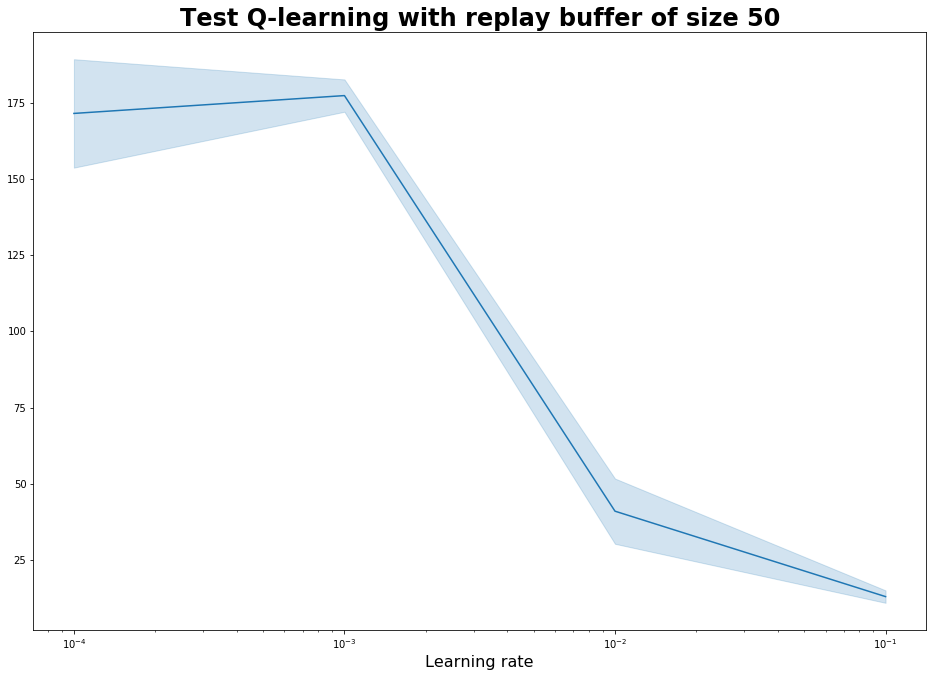

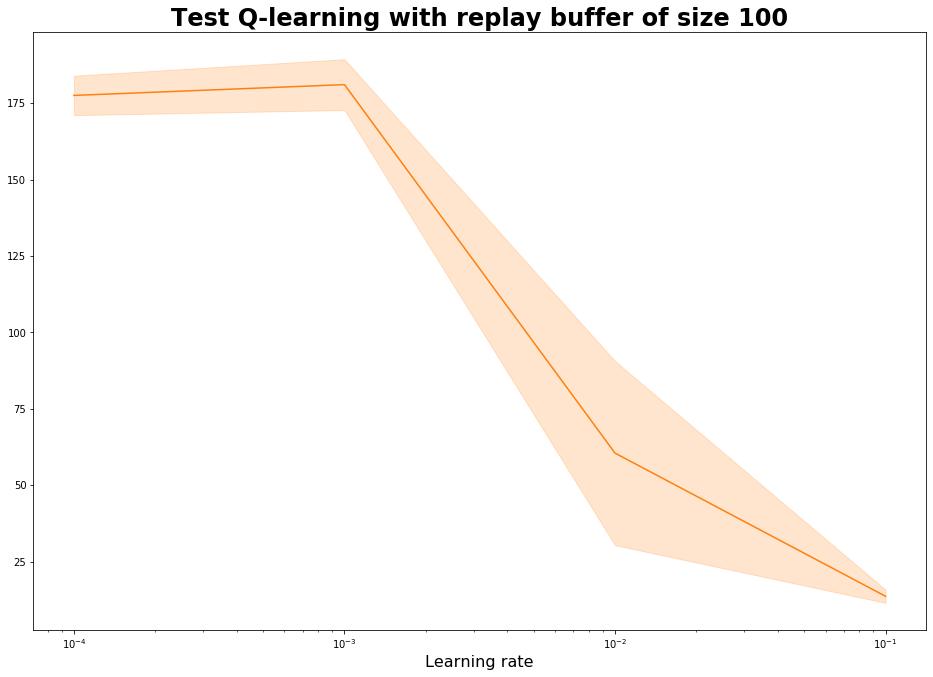

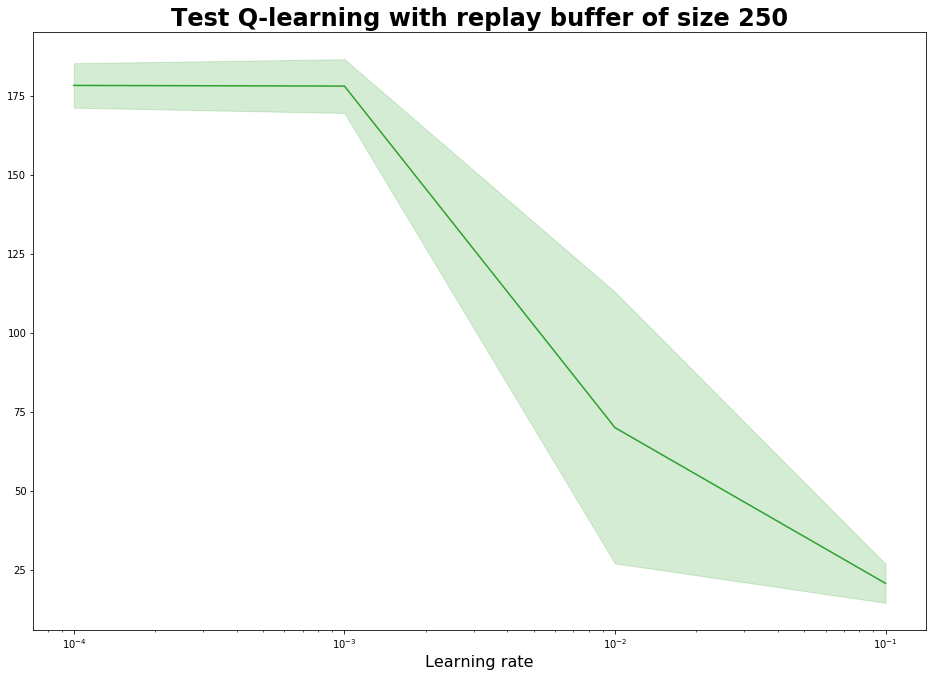

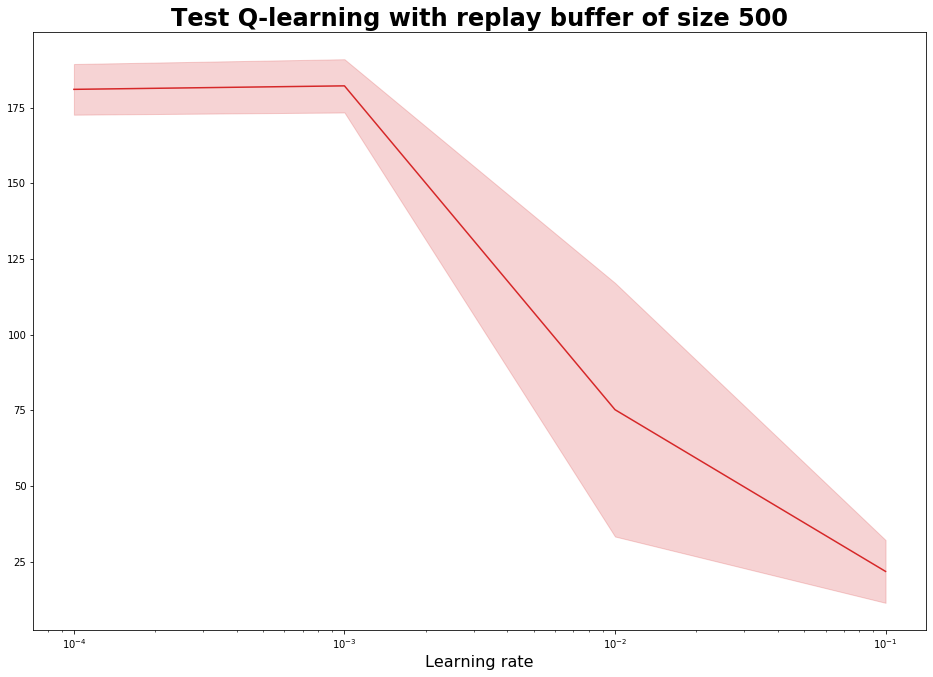

In [27]:
plot_algo_results(params_qlearning,test_cr_qlearning, test_cr_std_qlearning,"Q-learning")

Text(0.5, 0, 'Learning rate')

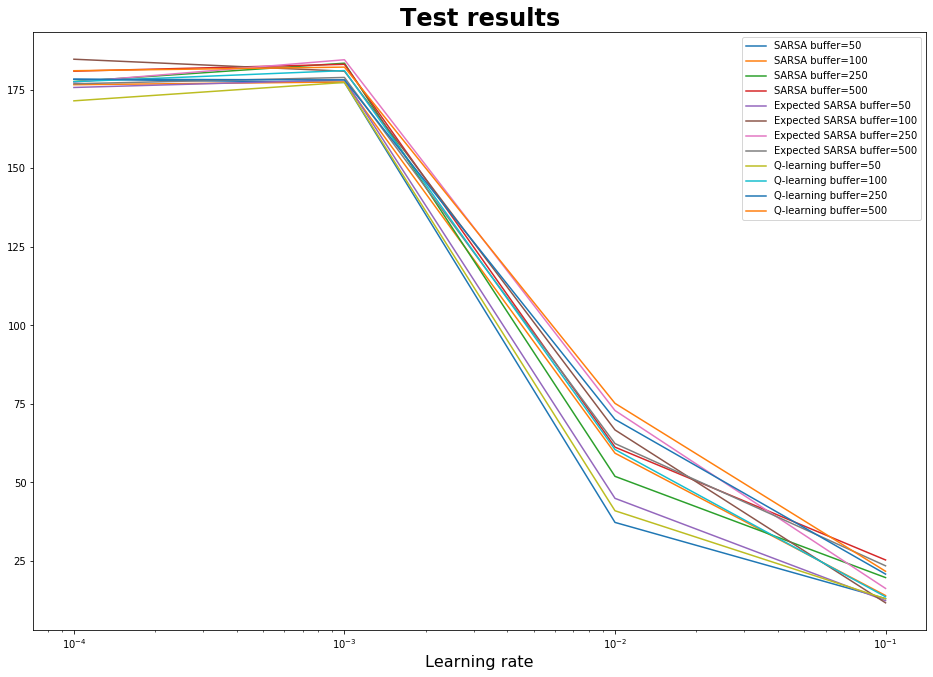

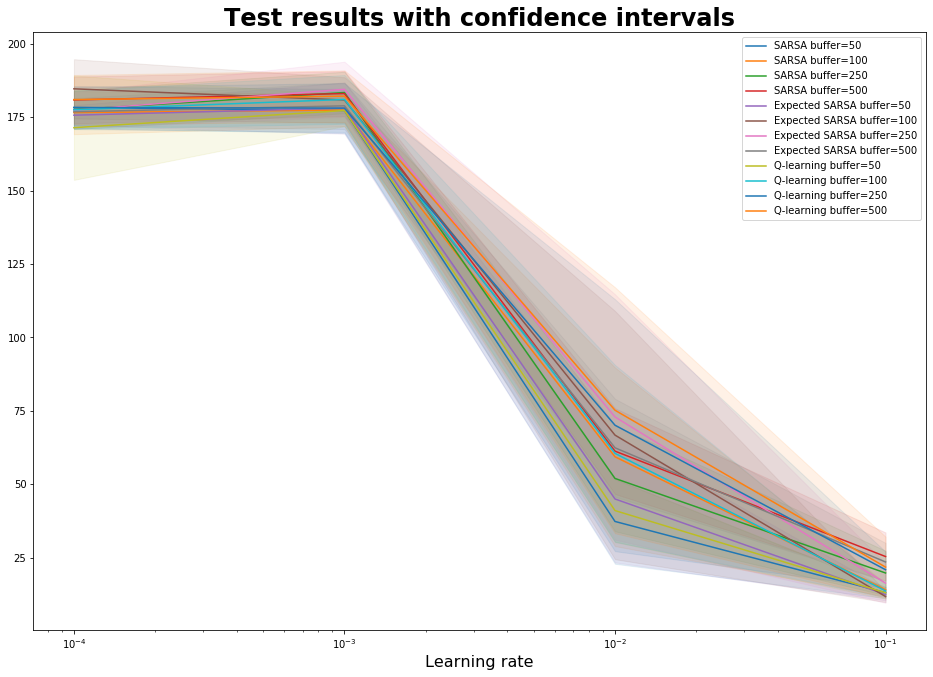

In [28]:
colors_ = cycle(mcolors.TABLEAU_COLORS)
fig1, ax1 = pyplot.subplots(figsize=(16,11))
fig2, ax2 = pyplot.subplots(figsize=(16,11))
def plot_all_algo_test_results(params,cum_rewards,cum_rewards_std,name):
    for rbs in replay_buffer_sizes:
        idxs = [i for i,(bs, lr) in enumerate(params) if bs == rbs]
        cr_ = cum_rewards[idxs]
        cr_std_ = cum_rewards_std[idxs]

        col = next(colors_)
        ax1.semilogx(learning_rates,cr_,c=col,label=f"{name} buffer={rbs}")
        ax2.semilogx(learning_rates,cr_,c=col,label=f"{name} buffer={rbs}")
        # confidence interval of one std is used here
        # so around 68% of all cureves shall fall into
        ax2.fill_between(learning_rates, cr_ - cr_std_, cr_ + cr_std_, color=col, alpha=0.1)      

# somwhere in the ideal universe this figure shall be very helpful
# to compare algorihms. In ours it is just a piece of modern art
plot_all_algo_test_results(params_sarsa,test_cr_sarsa, test_cr_std_sarsa,"SARSA")
plot_all_algo_test_results(params_esarsa,test_cr_esarsa, test_cr_std_esarsa,"Expected SARSA")
plot_all_algo_test_results(params_qlearning,test_cr_qlearning, test_cr_std_qlearning,"Q-learning")

ax1.set_title(f"Test results", fontsize=24, fontweight="bold")
ax2.set_title(f"Test results with confidence intervals", fontsize=24, fontweight="bold")
ax1.legend(loc="best")
ax2.legend(loc="best")
ax1.set_xlabel("Learning rate", fontsize=16)
ax2.set_xlabel("Learning rate", fontsize=16)

In [0]:
def get_best_paramets_idx(cum_reward):
    return np.argmax(cum_reward)

In [0]:
best_parameters_sarsa = get_best_paramets_idx(test_cr_sarsa)
best_parameters_esarsa = get_best_paramets_idx(test_cr_esarsa)
best_parameters_qlearning = get_best_paramets_idx(test_cr_qlearning)

In [31]:
print("Average iterations to converge:")
print(f"\tSARSA: {terminals_sarsa[:,best_parameters_sarsa].mean()}" )
print(f"\tExpected SARSA: {terminals_esarsa[:,best_parameters_esarsa].mean()}" )
print(f"\tQ-learning: {terminals_qlearning[:,best_parameters_qlearning].mean()}" )

Average iterations to converge:
	SARSA: 79.1
	Expected SARSA: 755.5
	Q-learning: 78.8


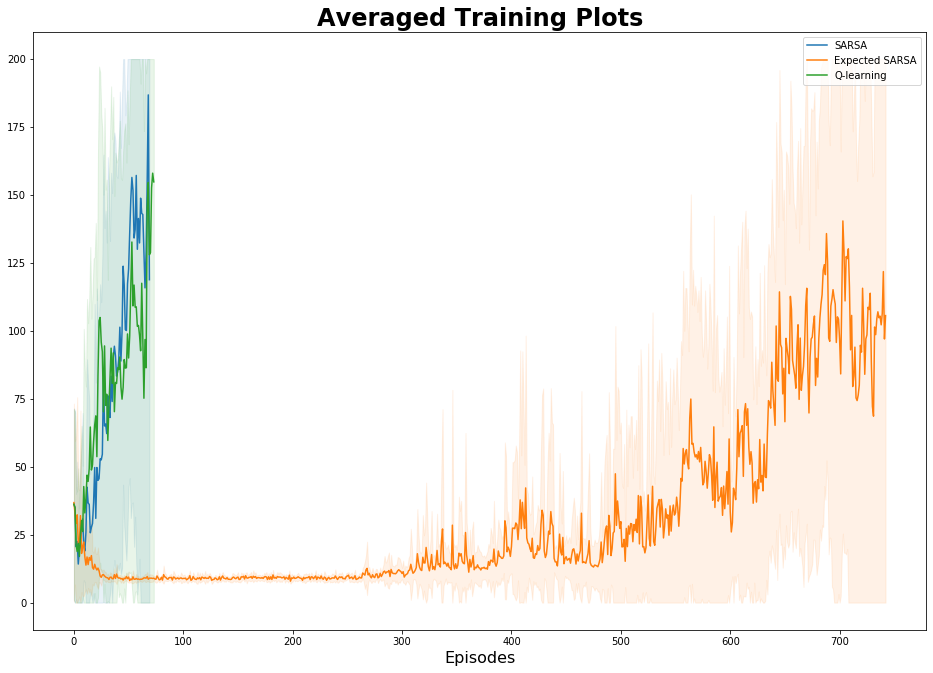

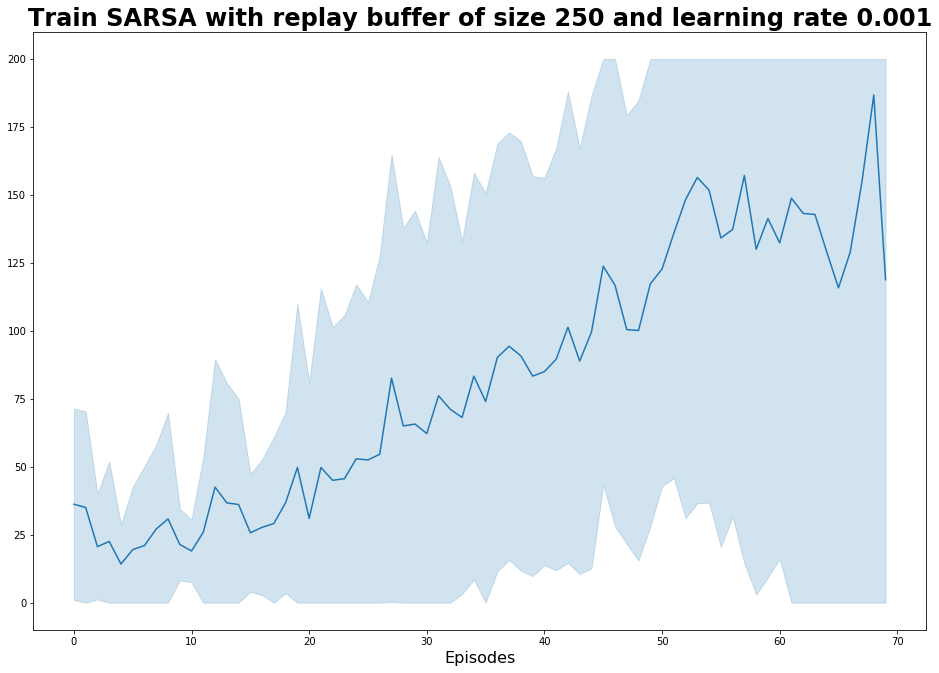

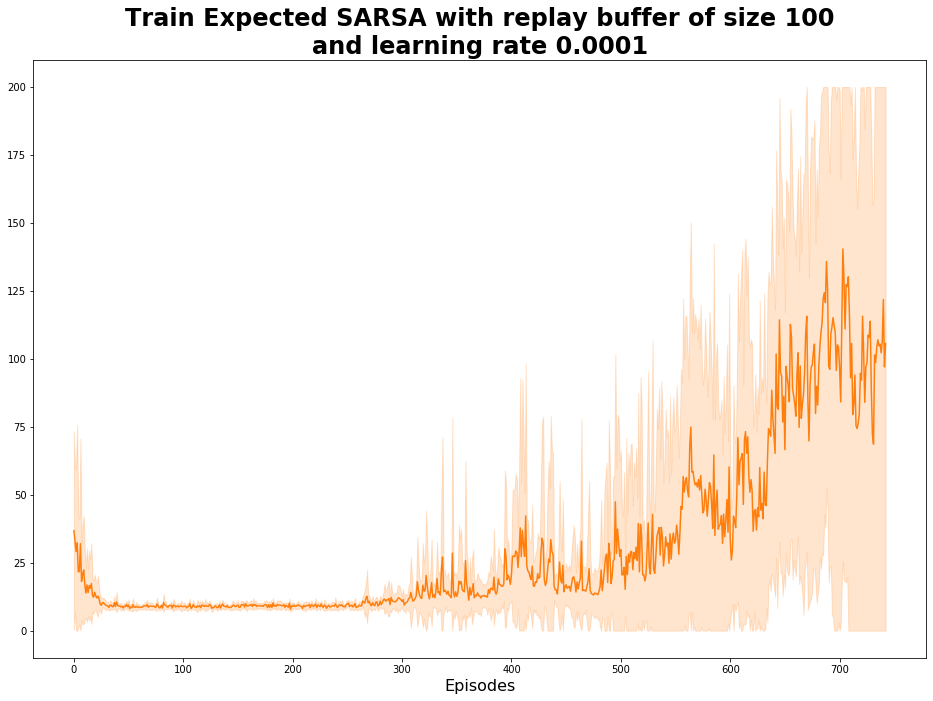

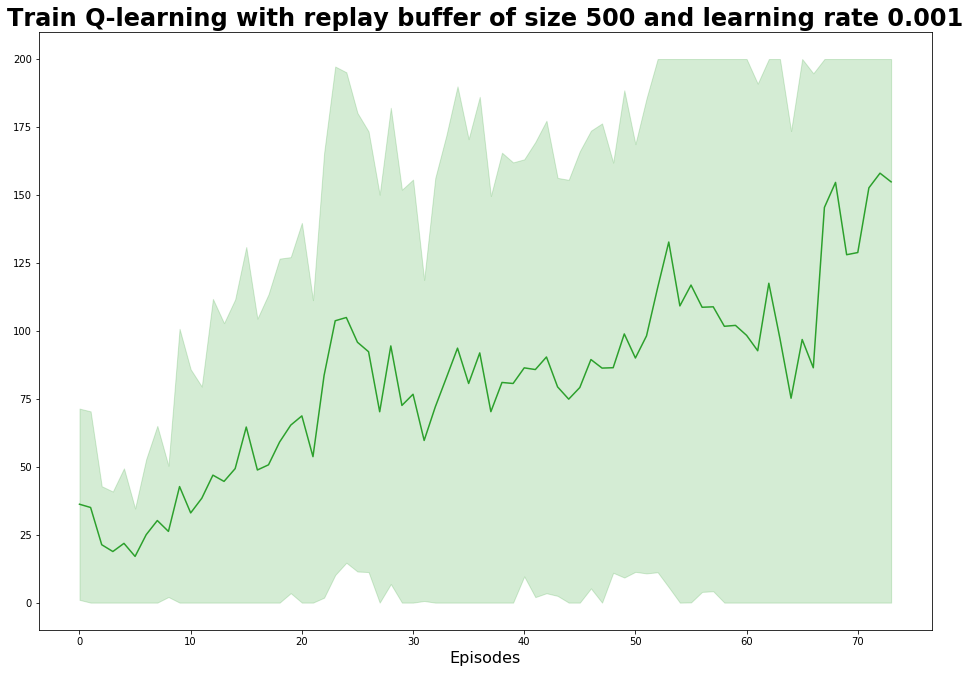

In [35]:
colors_ = cycle(mcolors.TABLEAU_COLORS)
fig, ax = pyplot.subplots(figsize=(16,11))

ax.set_xlabel("Episodes", fontsize=16)
ax.set_title("Averaged Training Plots", fontsize=24, fontweight="bold")

def plot_algo_best_results(train_cr,label,color):
    # averaging iteration where at least hafo of agent have not beeen stopped
    # by termination condition
    idx = (train_cr!=0).astype(np.int)
    border_index = np.argmin(idx.sum(axis=0)>=(NUM_TRIALS//2)) -1
    
    cr = train_cr[:,:border_index].sum(axis=0) / idx[:,:border_index].sum(axis=0)
    cr_std = ((train_cr[:,:border_index] - cr)**2).sum(axis=0) / idx[:,:border_index].sum(axis=0)
    cr_std = np.sqrt(cr_std)
    
    episodes = np.arange(cr.shape[0])
    ax.plot(episodes,cr,c=color,label=label)
    std_plus = np.minimum(cr + cr_std,200)
    std_minus = np.maximum(cr - cr_std,0)
    ax.fill_between(episodes, std_minus, std_plus, color=color, alpha=0.1)

    pyplot.subplots(figsize=(16,11))
    pyplot.plot(cr,c=color)
    pyplot.fill_between(episodes, std_minus, std_plus, color=color, alpha=0.2)
    pyplot.xlabel("Episodes", fontsize=16)

bs, lr = params_sarsa[best_parameters_sarsa]
plot_algo_best_results(train_cr_sarsa[:,best_parameters_sarsa,:],"SARSA",next(colors_))
pyplot.title("Train SARSA with replay buffer of size {} and learning rate {}".format(int(bs),lr), fontsize=24, fontweight="bold")
bs, lr = params_esarsa[best_parameters_esarsa]
plot_algo_best_results(train_cr_esarsa[:,best_parameters_esarsa,:],"Expected SARSA",next(colors_))
pyplot.title("Train Expected SARSA with replay buffer of size {}\nand learning rate {}".format(int(bs),lr), fontsize=24, fontweight="bold")
bs, lr = params_qlearning[best_parameters_qlearning]
plot_algo_best_results(train_cr_qlearning[:,best_parameters_qlearning,:],"Q-learning",next(colors_))
pyplot.title("Train Q-learning with replay buffer of size {} and learning rate {}".format(int(bs),lr), fontsize=24, fontweight="bold")

ax.legend(loc="best");

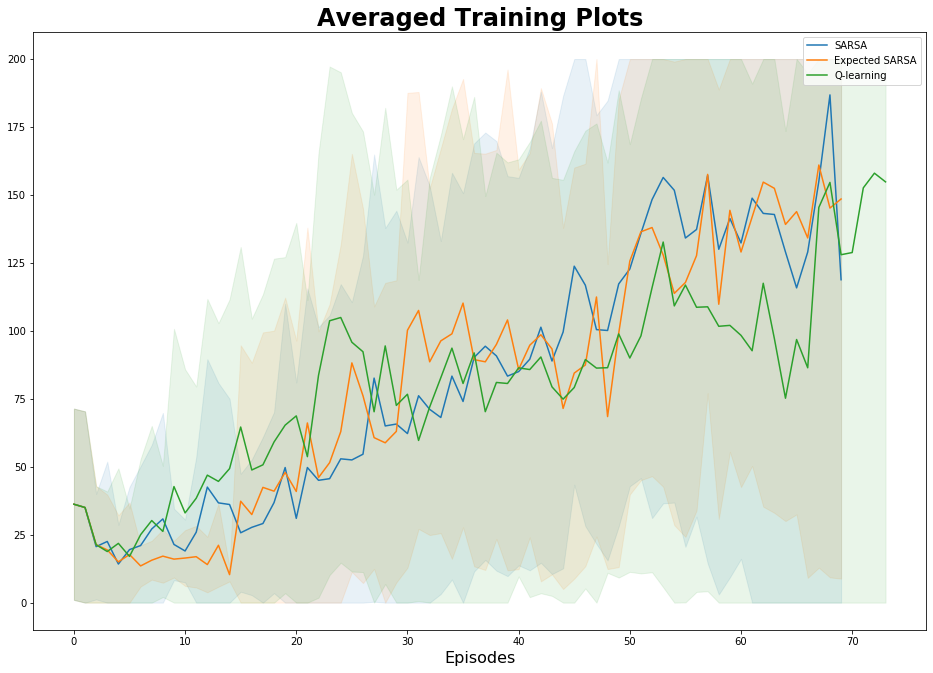

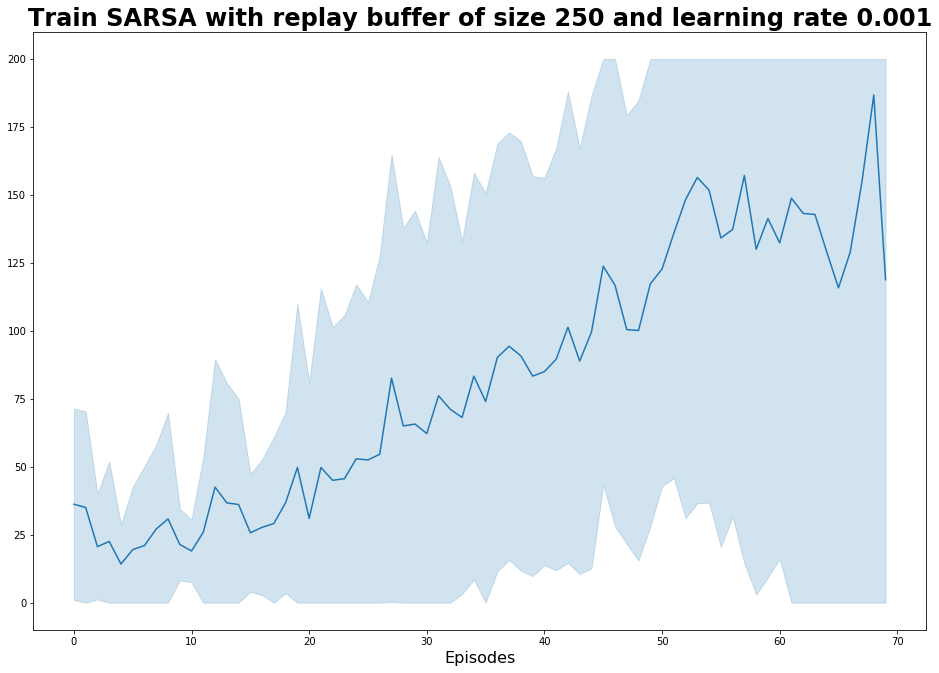

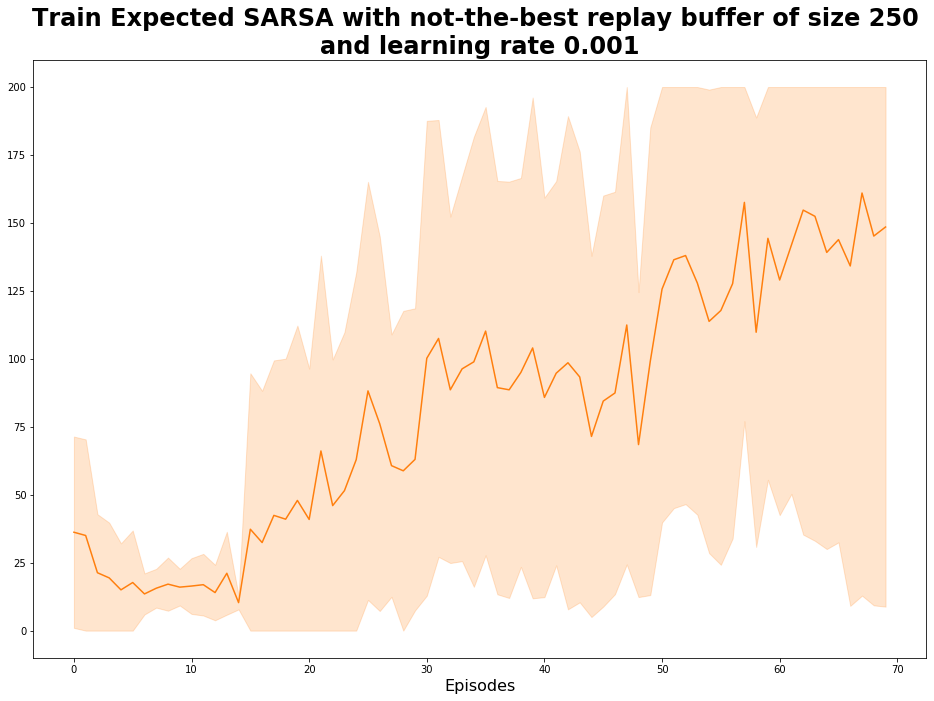

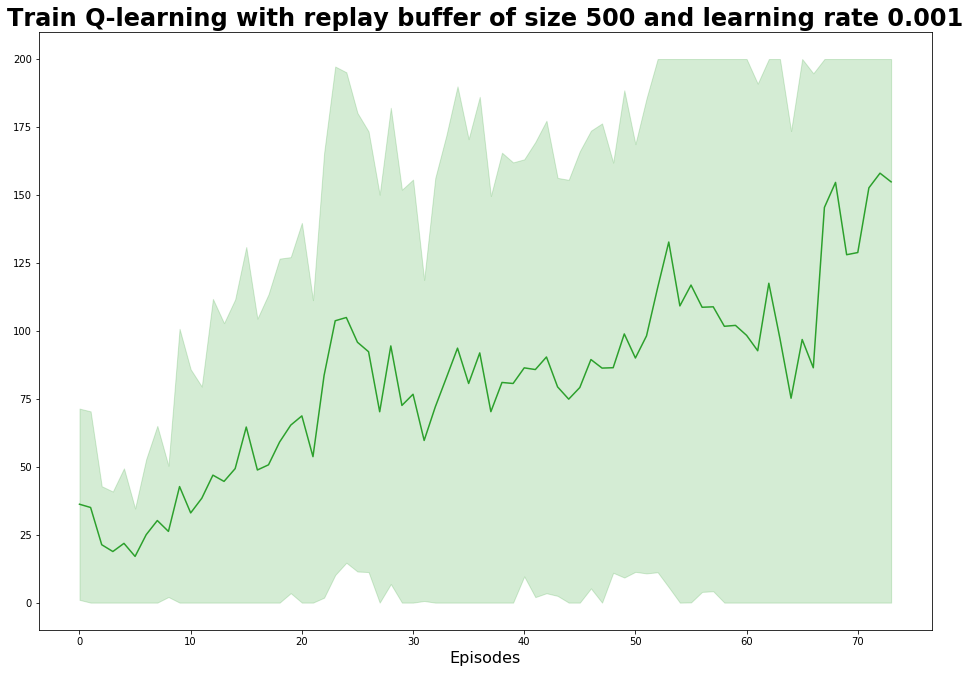

In [34]:
# Bonus plot: not_really_the_best_sarsa_parameters_choice.svg
colors_ = cycle(mcolors.TABLEAU_COLORS)
fig, ax = pyplot.subplots(figsize=(16,11))

ax.set_xlabel("Episodes", fontsize=16)
ax.set_title("Averaged Training Plots", fontsize=24, fontweight="bold")

bs, lr = params_sarsa[best_parameters_sarsa]
plot_algo_best_results(train_cr_sarsa[:,best_parameters_sarsa,:],"SARSA",next(colors_))
pyplot.title("Train SARSA with replay buffer of size {} and learning rate {}".format(int(bs),lr), fontsize=24, fontweight="bold")
bs, lr = params_esarsa[9]
plot_algo_best_results(train_cr_esarsa[:,9,:],"Expected SARSA",next(colors_))
pyplot.title("Train Expected SARSA with not-the-best replay buffer of size {} \nand learning rate {}".format(int(bs),lr), fontsize=24, fontweight="bold")
bs, lr = params_qlearning[best_parameters_qlearning]
plot_algo_best_results(train_cr_qlearning[:,best_parameters_qlearning,:],"Q-learning",next(colors_))
pyplot.title("Train Q-learning with replay buffer of size {} and learning rate {}".format(int(bs),lr), fontsize=24, fontweight="bold")

ax.legend(loc="best");

### Results

I. With right hyperparameters all of the algorhms were observed converge slowly but almost surely.

II. Variance in episode return during training is quite high. In some cases we have dispersion over the whole range of rewards. 

III. We tested learning rates and replay buffer sizes. Regarding learning rate everything is clear: lower is better, but not to low or else it does not learn. In the best results set learning rate of 0.001 is prevailing. Regarding replay buffer size there is no clear correlation between the size and performance of variance of performance.however it seems more natural that buffer should be of sevaral expected episodes sizes. Thus there will be minimum of "bad" trajectories.

IV. The best train results for SARSA shows that it reqiures over 700 steps to converge whereas othes require less than a hundred. However, training resuls become more consistant (in terms of time and learning rate choice) in case we choose another hyperparameter set for comparison. I presume it is a result of unsertanty.